In this notebook, we will use ARIMA, Prophet, and LSTM to predict daily minimum temperatures. Here are the main ideas for the three models:

- ARIMA Model: First, check if the time series is stationary by plotting and using the ADF test. If it's non-stationary, apply differencing. The 'd' in ARIMA represents the number of differencing needed. Afterward, use ACF and PACF plots to determine the 'p' and 'q' terms in ARIMA. An easier approach is to employ auto ARIMA.

- Prophet: This model requires only two parameters: 'ds' (representing time) and 'y' (the minimum temperatures). There's no need to check for stationarity, as Prophet can adeptly handle seasonal and trend effects.

- LSTM: This neural network uses a gated architecture to manage information over long sequences, making it well-suited for time series prediction. However, for computation acceleration, a GPU is necessary.

For further reference, you can explore the link below, which has been highly informative in shaping these ideas:

https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df = pd.read_csv('data/daily-minimum-temperatures-in-me.csv')

***1. Data cleaning***

We will explore the data, check if there are missing values, and parse date into day, week, month, and season.

In [3]:
df.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [4]:
df.tail()

,Date,Daily minimum temperatures
3645,12/27/1990,14
3646,12/28/1990,13.6
3647,12/29/1990,13.5
3648,12/30/1990,15.7
3649,12/31/1990,13


We can see that the data consists of the minimum temperatures in 10 years from 1/1/1981 to 31/12/1990.

In [5]:
# Check if there are missing values
df.isna().sum()

Date                          0
Daily minimum temperatures    0
dtype: int64

In [6]:
df.describe()

,Date,Daily minimum temperatures
count,3650,3650
unique,3650,230
top,1/1/1981,11
freq,1,51


In [7]:
# Change the format and add more features for time series data
df['date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [8]:
# Rename column
df = df.rename(columns = {'Daily minimum temperatures': 'min_temp'})

In [9]:
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    if month in [3, 4, 5]:
        return 0
    if month in [6, 7, 8]:
        return 1
    if month in [9, 10, 11]:
        return 2

df['season'] = df['month'].apply(get_season)
df.head()

,Date,min_temp,date,day,week,month,year,season
0,1/1/1981,20.7,1981-01-01,1,1,1,1981,3
1,1/2/1981,17.9,1981-01-02,2,1,1,1981,3
2,1/3/1981,18.8,1981-01-03,3,1,1,1981,3
3,1/4/1981,14.6,1981-01-04,4,1,1,1981,3
4,1/5/1981,15.8,1981-01-05,5,2,1,1981,3


In [10]:
df['year'].value_counts()

year
1981    365
1982    365
1983    365
1984    365
1985    365
1986    365
1987    365
1988    365
1989    365
1990    365
Name: count, dtype: int64

In [11]:
df['month'].value_counts()

month
1     310
3     310
5     310
7     310
8     310
10    310
12    308
4     300
6     300
9     300
11    300
2     282
Name: count, dtype: int64

In [12]:
df['day'].value_counts()

day
1     120
2     120
28    120
27    120
26    120
25    120
24    120
23    120
22    120
21    120
20    120
19    120
18    120
17    120
16    120
15    120
14    120
13    120
12    120
11    120
10    120
9     120
8     120
7     120
6     120
5     120
4     120
3     120
29    112
30    110
31     68
Name: count, dtype: int64

In [13]:
df['week'].value_counts()

week
27    70
39    70
29    70
30    70
31    70
32    70
33    70
34    70
35    70
36    70
37    70
38    70
40    70
2     70
41    70
42    70
43    70
44    70
45    70
46    70
47    70
48    70
49    70
50    70
28    70
26    70
14    70
13    70
3     70
4     70
5     70
6     70
7     70
8     70
9     70
10    70
11    70
12    70
51    70
25    70
15    70
16    70
17    70
18    70
19    70
20    70
21    70
22    70
23    70
24    70
52    69
1     67
53    14
Name: count, dtype: Int64

In [14]:
df['min_temp'].unique()

array(['20.7', '17.9', '18.8', '14.6', '15.8', '17.4', '21.8', '20',
       '16.2', '13.3', '16.7', '21.5', '25', '20.6', '24.8', '17.7',
       '15.5', '18.2', '12.1', '14.4', '16', '16.5', '18.7', '19.4',
       '17.2', '15.1', '15.4', '15.3', '21.9', '19.9', '16.6', '16.8',
       '17.1', '15', '13.7', '13.9', '18.3', '22', '22.1', '21.2', '18.4',
       '16.1', '15.7', '18.5', '16.9', '17.5', '17.8', '18.6', '17',
       '14.3', '11.4', '16.3', '11.8', '12.2', '14.7', '11.3', '10.6',
       '11.7', '14.2', '11.2', '8.1', '8', '8.8', '13.4', '10.9', '11',
       '14.5', '18.1', '10', '14.9', '15.9', '13', '7.6', '11.5', '13.5',
       '12.4', '13.2', '13.8', '9', '9.8', '8.9', '7.4', '9.9', '9.3',
       '8.6', '11.9', '14', '12', '10.5', '10.7', '10.1', '5.3', '6.6',
       '8.5', '5.9', '3.2', '2.1', '3.4', '5.4', '9.6', '12.3', '12.6',
       '12.8', '11.6', '5.7', '7.1', '2.5', '3.5', '4.6', '7.7', '10.4',
       '9.2', '6.1', '2.7', '4.3', '6.3', '3.8', '4.4', '4.8', '5.8',
   

We can see that some values in min_temp have question marks. We can remove them.

In [15]:
df['min_temp'] = df['min_temp'].str.replace('?', '', regex=False)

In [16]:
df['min_temp'] = pd.to_numeric(df['min_temp'])

In [17]:
# Check again
df['min_temp'].unique()

array([20.7, 17.9, 18.8, 14.6, 15.8, 17.4, 21.8, 20. , 16.2, 13.3, 16.7,
       21.5, 25. , 20.6, 24.8, 17.7, 15.5, 18.2, 12.1, 14.4, 16. , 16.5,
       18.7, 19.4, 17.2, 15.1, 15.4, 15.3, 21.9, 19.9, 16.6, 16.8, 17.1,
       15. , 13.7, 13.9, 18.3, 22. , 22.1, 21.2, 18.4, 16.1, 15.7, 18.5,
       16.9, 17.5, 17.8, 18.6, 17. , 14.3, 11.4, 16.3, 11.8, 12.2, 14.7,
       11.3, 10.6, 11.7, 14.2, 11.2,  8.1,  8. ,  8.8, 13.4, 10.9, 11. ,
       14.5, 18.1, 10. , 14.9, 15.9, 13. ,  7.6, 11.5, 13.5, 12.4, 13.2,
       13.8,  9. ,  9.8,  8.9,  7.4,  9.9,  9.3,  8.6, 11.9, 14. , 12. ,
       10.5, 10.7, 10.1,  5.3,  6.6,  8.5,  5.9,  3.2,  2.1,  3.4,  5.4,
        9.6, 12.3, 12.6, 12.8, 11.6,  5.7,  7.1,  2.5,  3.5,  4.6,  7.7,
       10.4,  9.2,  6.1,  2.7,  4.3,  6.3,  3.8,  4.4,  4.8,  5.8,  6.2,
        7.3, 10.2,  9.5,  6.5,  7. ,  8.3,  6.8,  7.2,  5. ,  6.9,  5.2,
        3. ,  5.6,  7.9, 10.3,  9.7, 12.5,  3.9,  6. ,  5.5,  7.5,  7.8,
       14.1, 12.9,  9.1,  8.4, 13.6,  9.4, 14.8, 16

***2. Data visualization***

In this section, we will visualize the data to see how min_temp is distributed, detect and remove outliers, and gain some knowledge about the average min temperatures over time.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='min_temp', ylabel='Count'>

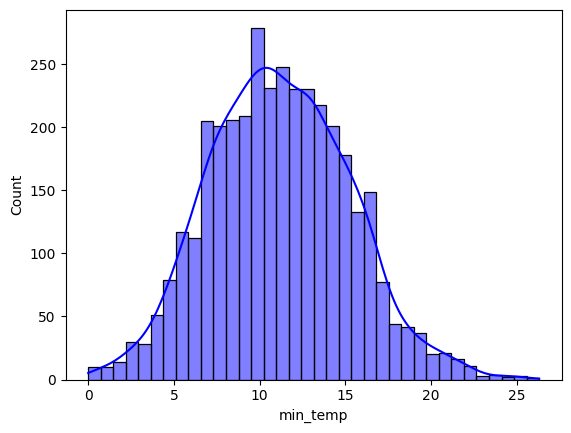

In [19]:
sns.histplot(
    data = df,
    x = 'min_temp',
    kde = True,
    color = 'blue'
)

We can see that the distribution of min_temp is likely normal.

In [20]:
# Convert min_temp to numeric
df['min_temp'] = pd.to_numeric(df['min_temp'])

<Axes: xlabel='min_temp'>

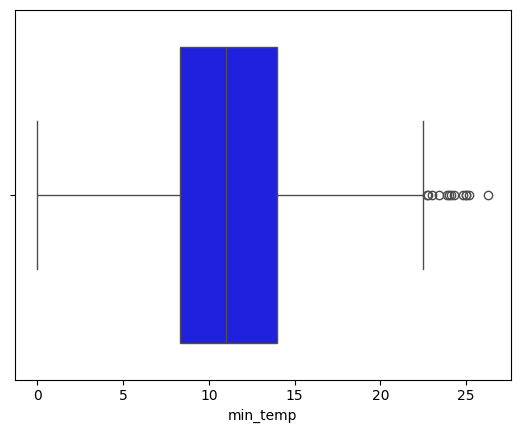

In [21]:
sns.boxplot(
    data = df,
    x = 'min_temp',
    color = 'blue'
)

We can see that there are outliers. In order to decide if we should remove them, we need to check the average of min_temp over time.

<Axes: xlabel='season', ylabel='min_temp'>

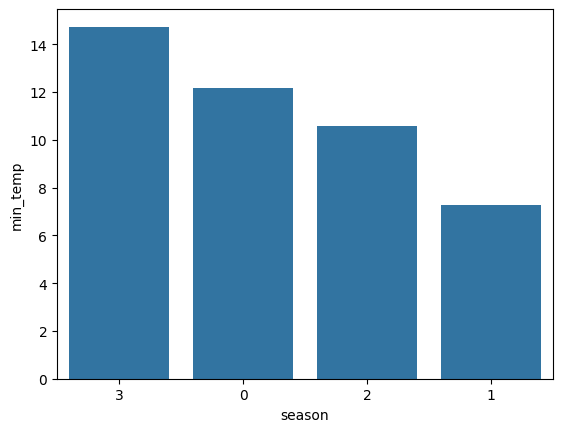

In [22]:
index_season = df.groupby('season')['min_temp'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'season',
    y = 'min_temp',
    order = index_season,
    errorbar = None,
    estimator=np.mean
)

min_temp is highest in December, January and February, and lowest in June, July and August. 

<Axes: xlabel='month', ylabel='min_temp'>

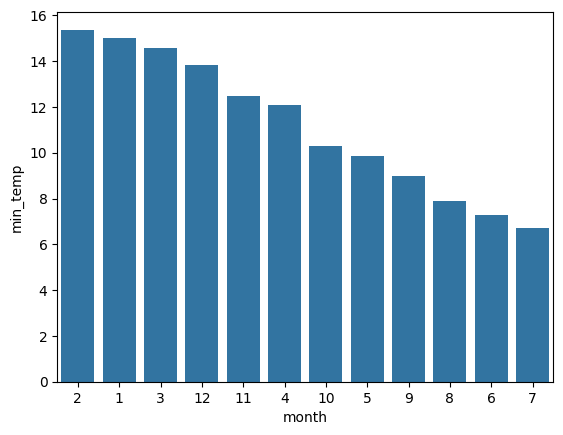

In [23]:
index_month = df.groupby('month')['min_temp'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'month',
    y = 'min_temp',
    order = index_month,
    errorbar = None,
    estimator=np.mean
)

<Axes: xlabel='week', ylabel='min_temp'>

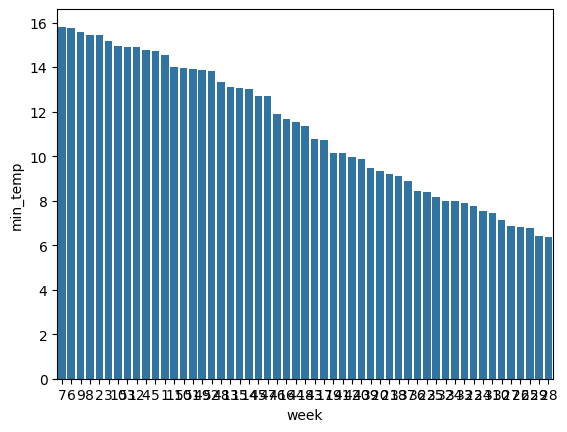

In [24]:
index_week = df.groupby('week')['min_temp'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'week',
    y = 'min_temp',
    order = index_week,
    errorbar = None,
    estimator=np.mean
)

<Axes: xlabel='year', ylabel='min_temp'>

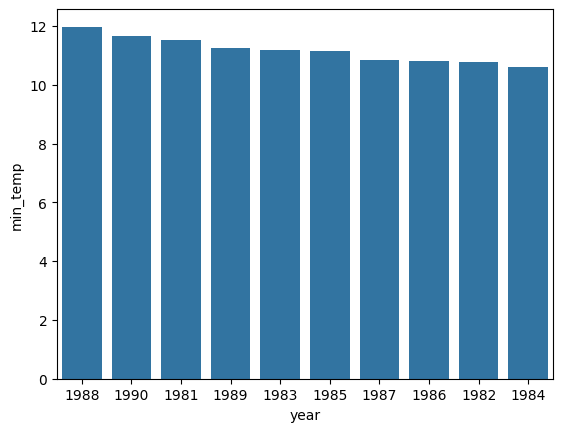

In [25]:
index_year = df.groupby('year')['min_temp'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'year',
    y = 'min_temp',
    order = index_year,
    errorbar = None,
    estimator=np.mean
)

The min temperature does not change much over year. We already see that the highest average min_temp weekly is around 16, and we can reomve outliers when min_temp > 20.

In [26]:
# Outliers when min_temp > 20
days_above_20 = df['min_temp'] > 20

# Count the number of True values in the series, which is equivalent to counting the days
count_days_above_20 = days_above_20.sum()

print(count_days_above_20)

74


In [27]:
# Remove outliers
df = df[df['min_temp'] <= 20]

<Axes: xlabel='min_temp'>

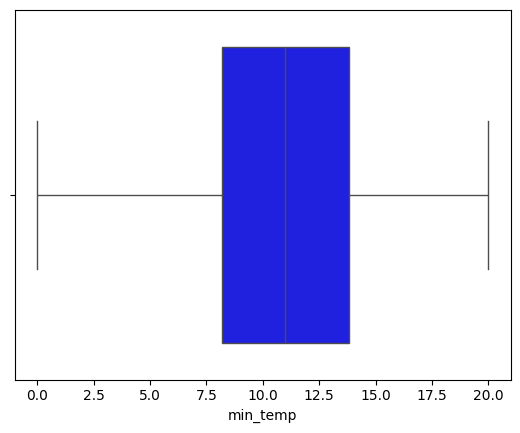

In [28]:
# Check 
sns.boxplot(
    data = df,
    x = 'min_temp',
    color = 'blue'
)

***3. ADF test***

Recall that we need to check if the time series is stationary before using ARIMA, and in this section, we will perform the ADF test for min_temp.

If ADF statistic < critical values 1%, and p-value < 0.05, we can conclude our time series is stationary.

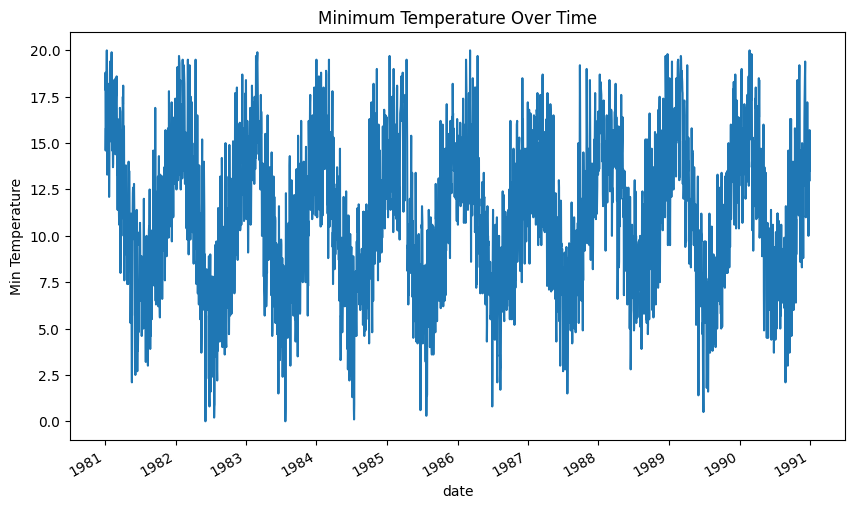

In [29]:
# Plot min_temp over time indexed by date
df.set_index('date', inplace=True)
df['min_temp'].plot(figsize=(10, 6), title='Minimum Temperature Over Time')
plt.xlabel('date')
plt.ylabel('Min Temperature')
plt.show()

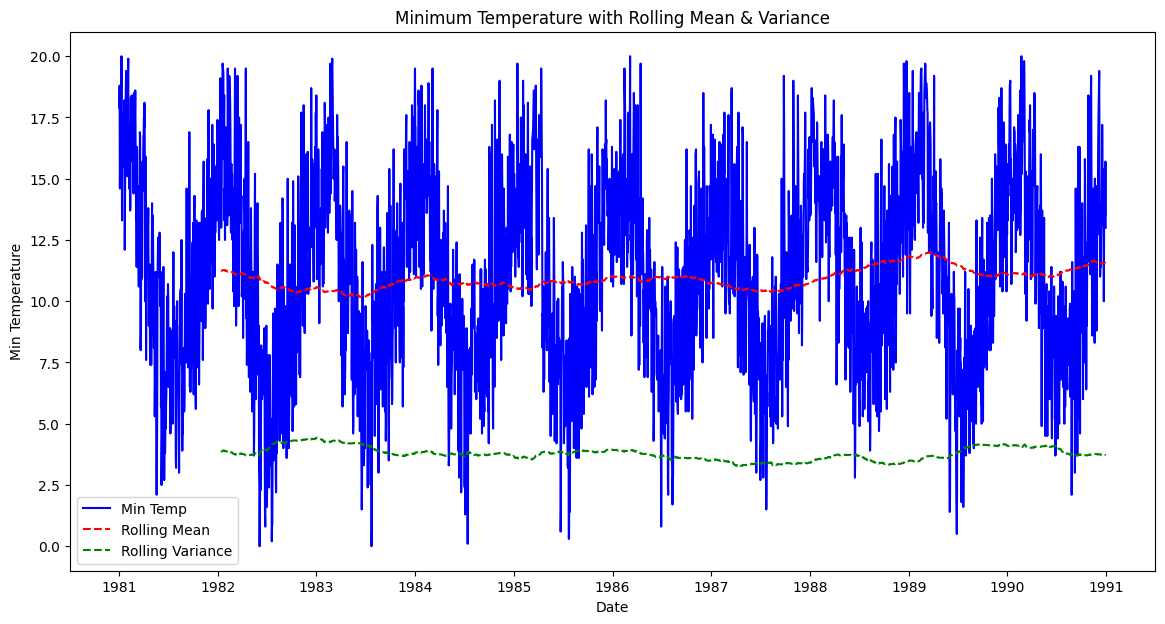

In [30]:
# Because it is daily data, we can choose the rolling windown = 365
rolling_mean = df['min_temp'].rolling(window=365).mean()
rolling_var = df['min_temp'].rolling(window=365).std()

# Plotting the time series along with the rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(df['min_temp'], label='Min Temp', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.plot(rolling_var, label='Rolling Variance', color='green', linestyle='--')
plt.title('Minimum Temperature with Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.legend()
plt.show()

In [31]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['min_temp'].values)
result

(-4.521583317789982,
 0.00017971621234682145,
 17,
 3558,
 {'1%': -3.4321892422972575,
  '5%': -2.8623526737372837,
  '10%': -2.5672025996313876},
 16000.456931808498)

ADF statistic = -4.5 < critical value 1% = -3.4 and p-value = 0.00017 < 0.05, we can conclude that the time series is stationary. This implies that there is no trend in the min_temp (but not exclude seasonality).

***4. ACF and PACF plot***

In the ADF test, we know that we do not need to difference the time series, and hence d = 0. However, we need to determine p and q.

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

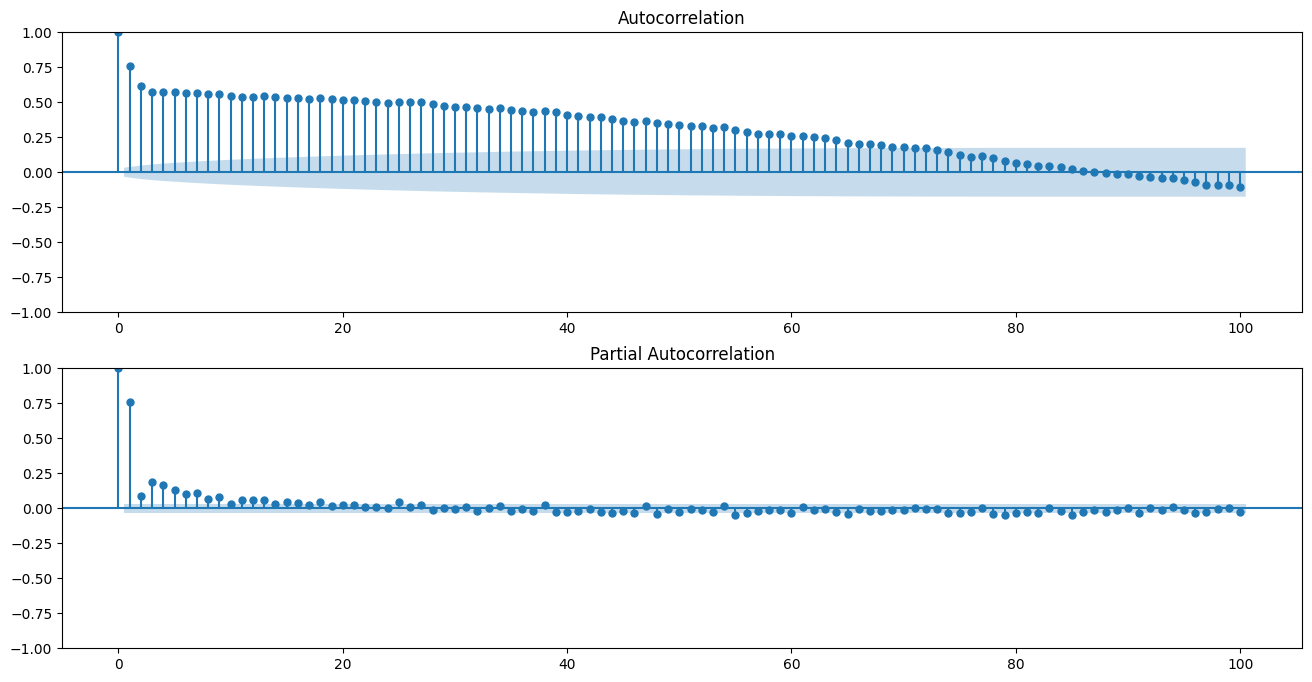

In [33]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['min_temp'], lags=100, ax=ax[0])
plot_pacf(df['min_temp'], lags=100, ax=ax[1])

plt.show()

The ACF plot shows a gradual decline, which is typical for a series that has been differenced. However, the fact that the autocorrelation remains significant for many lags suggests there might still be some seasonality in the data, or it could be an indication of a long memory process. 

The PACF plot shows a significant spike at lag 1 and then cuts off, which suggests a possible AR(1) component might be appropriate for the series. After the first lag, the partial autocorrelations are not significantly different from zero.

***5. Time series decomposition***

In this section, we will decompose and plot the components of time series, including trend, season and error.

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

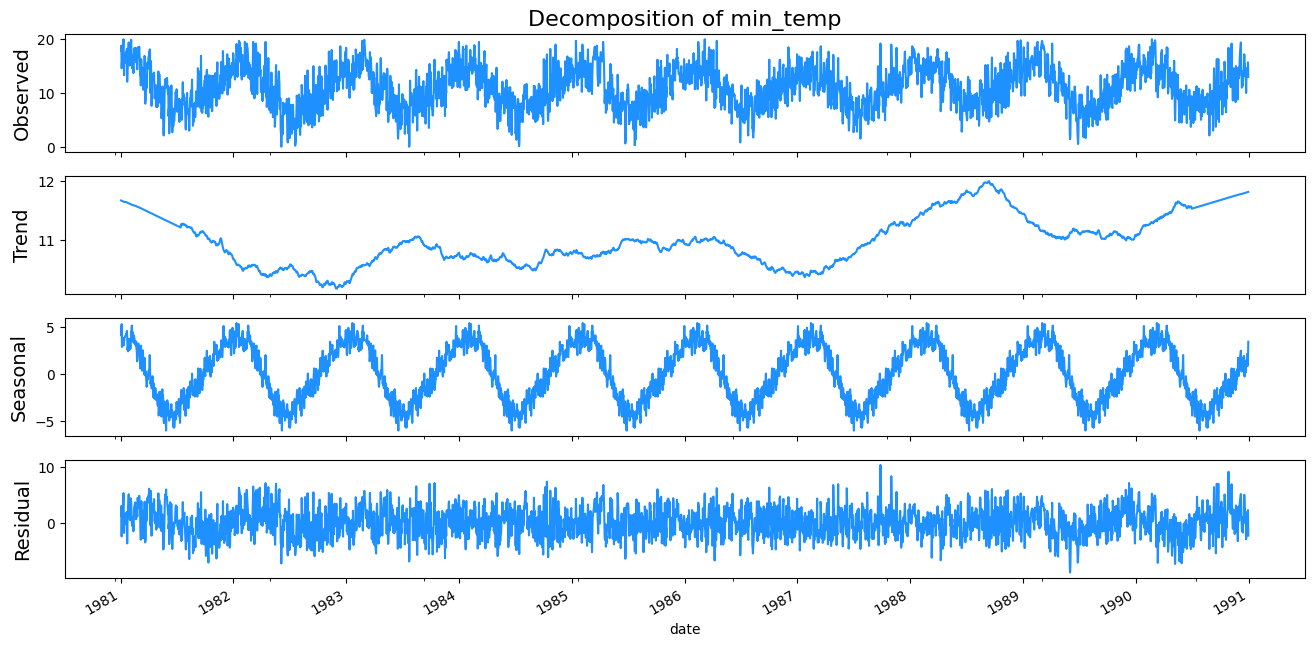

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df['min_temp'], period = 365, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of min_temp', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

Here is an explanation for the plots

Observed: This is the original time series data.

Trend: This shows the long-term progression of the series, highlighting any consistent increase or decrease over time. It appears that the trend component is relatively flat, suggesting no strong long-term trend in the data.

Seasonal: This captures regular patterns that repeat over time. The clear and consistent up-and-down pattern in the seasonal component suggests a strong seasonal effect, which is to be expected with temperature data.

Residual: These are the irregularities in the data that are not explained by the trend or seasonal components. Ideally, if the trend and seasonal components have been properly estimated, the residuals should resemble white noise (no discernible pattern).

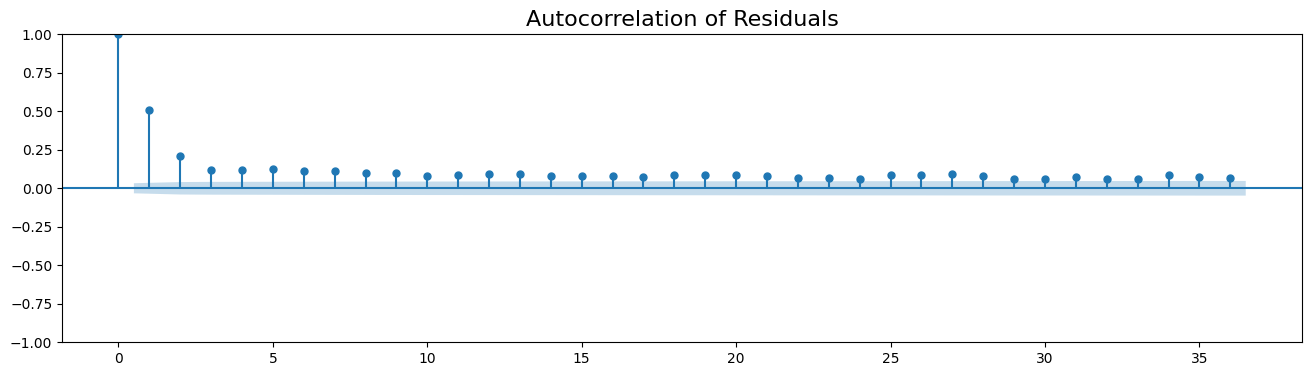

In [36]:
# Perform ACF on the residuals
plt.figure(figsize=(16, 4))
plot_acf(res.resid.dropna(), ax=plt.gca())
plt.title('Autocorrelation of Residuals', fontsize=16)
plt.show()

There's a significant spike at lag 1, which suggests some autocorrelation at that lag.
The autocorrelation at lag 1 is positive, indicating a direct relationship between a value and its immediate predecessor. 

The rest of the autocorrelation coefficients for higher lags appear to be within the confidence interval suggesting no significant autocorrelation at those lags.

It is no surprise, because the PACF already shows that p should be 1.

***6. Non-seasonal ARIMA***

In this section, we will try auto ARIMA model with seasonal = False.

In [37]:
!pip install -qqq pmdarima

In [38]:
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split

In [39]:
# Split the dataset
train, test = train_test_split(df['min_temp'], test_size=0.2, shuffle=False)

In [40]:
# Apply Auto ARIMA with seasonal = False
auto_arima_model = auto_arima(train, 
                              seasonal=False, 
                              trace=True,
                              m = 1,
                              error_action='ignore', 
                              suppress_warnings=True)

# Summary of the fitted model
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12999.436, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22098.487, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13720.920, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19056.006, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13020.544, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13030.750, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=12998.772, Time=0.77 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=12996.872, Time=0.68 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16401.158, Time=0.47 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=13000.095, Time=0.48 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=17350.298, Time=0.35 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=15849.145, Time=0.58 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=13000.513, Time=1.27 sec
 ARIMA(1,0,3)(0,0,0)[0] i

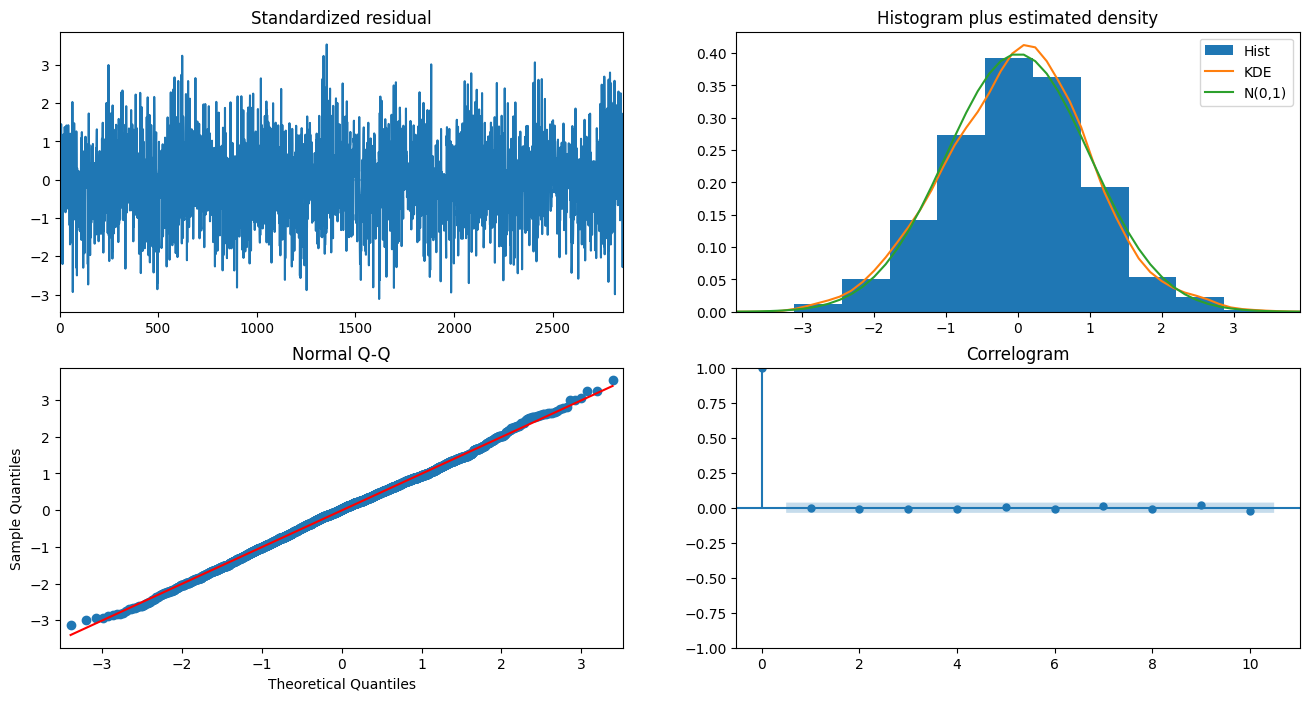

In [41]:
# Plot diagnostics
auto_arima_model.plot_diagnostics(figsize=(16,8))
plt.show()

Interpretion for the plotting results:

***Top left:*** The residual terms seem to fluctuate around a mean of zero and have a uniform variance between (-3, 3).

***Top Right:*** The density plot suggest the distribution is quite close to N(0,1).

***Bottom left:*** It seems that the distribution is not skewed.

***Bottom Right:*** The ACF plot shows the residual errors are not autocorrelated.

In [42]:
# Make predictions and compute RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Make predictions on the training set
train_predictions = auto_arima_model.predict_in_sample(start=0, end=len(train)-1)

# Make predictions on the test set
test_predictions = auto_arima_model.predict(n_periods=len(test))

# Calculate RMSE for the training set
train_rmse = sqrt(mean_squared_error(train, train_predictions))

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, test_predictions))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 2.339779907857315
Testing RMSE: 3.8601867396695897


/Users/khanhdam/.local/share/virtualenvs/ARIMA_Prophet_LSTM_TimeSeries-PUFzfPZF/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/khanhdam/.local/share/virtualenvs/ARIMA_Prophet_LSTM_TimeSeries-PUFzfPZF/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


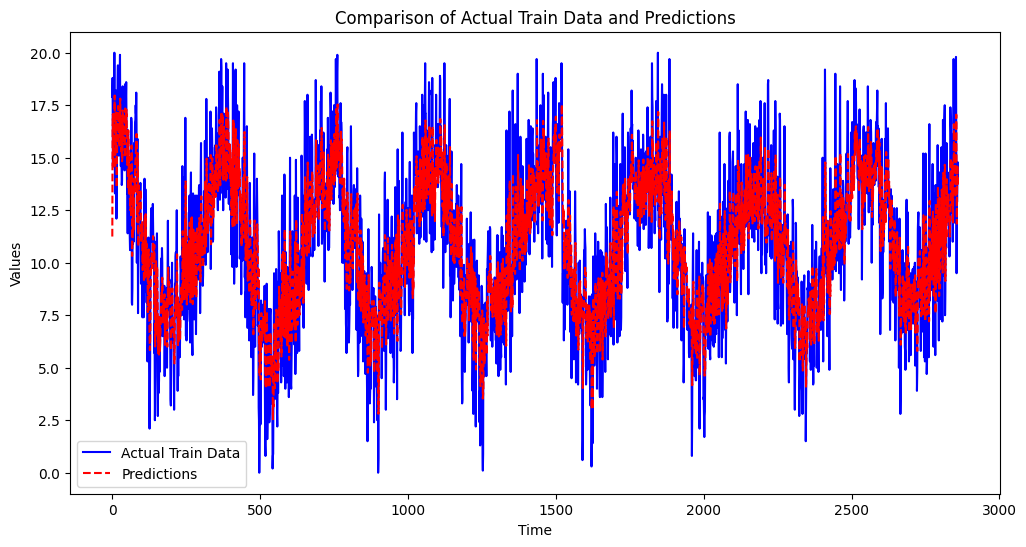

In [43]:
# Plotting the prediction for training set
plt.figure(figsize=(12, 6))
plt.plot(train.reset_index(drop=True), label='Actual Train Data', color='blue')
plt.plot(train_predictions.reset_index(drop=True), label='Predictions', color='red', linestyle='--')
plt.title('Comparison of Actual Train Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

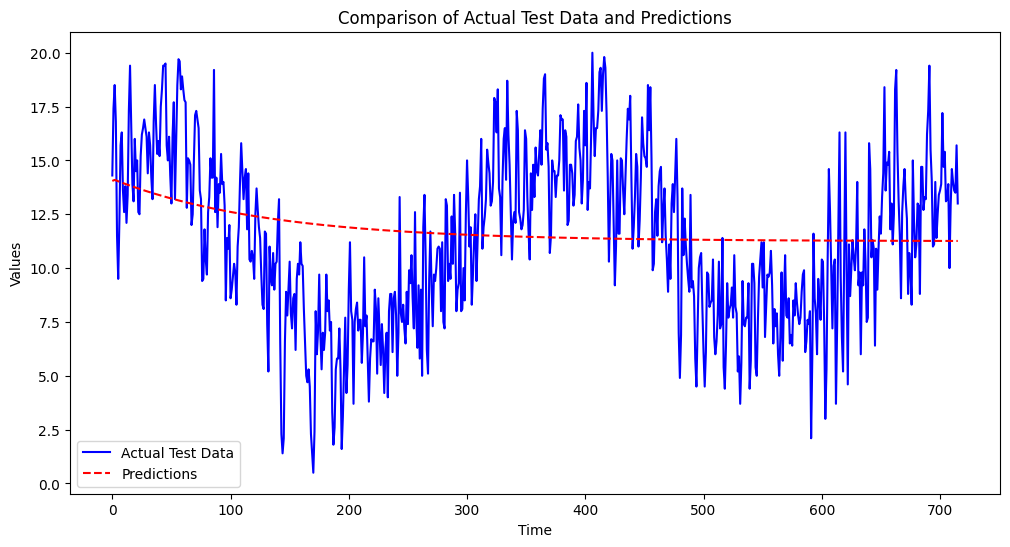

In [44]:
# Plotting the predictions for test data 
plt.figure(figsize=(12, 6))
plt.plot(test.reset_index(drop=True), label='Actual Test Data', color='blue')
plt.plot(test_predictions.reset_index(drop=True), label='Predictions', color='red', linestyle='--')
plt.title('Comparison of Actual Test Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

From this, we can see that the ARIMA model with seasonal = False does not capture well the seasonal component, and it seems to be overfit on the training data.

***7. Seasonal ARIMA***

We will apply auto ARIMA with seasonal = True in this section and compare the two models.

In [45]:
# Apply Auto ARIMA with seasonal = True
s_auto_arima_model = auto_arima(train, 
                              seasonal=True, 
                              trace=True,
                              m = 1,
                              error_action='ignore', 
                              suppress_warnings=True)

# Summary of the fitted model
print(s_auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12989.348, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15732.618, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13376.994, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14257.552, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22098.487, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=13008.926, Time=0.84 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13021.043, Time=0.99 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12988.343, Time=1.54 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12986.066, Time=1.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=13255.640, Time=0.44 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=12987.985, Time=1.58 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13355.678, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=13182.813, Time=0.59 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=12988.478, Time=1.86 sec
 ARIMA(3,0,1)(0,0,0

In [46]:
# Make predictions on the training set
train_predictions = s_auto_arima_model.predict_in_sample(start=0, end=len(train)-1)

# Make predictions on the test set
test_predictions = s_auto_arima_model.predict(n_periods=len(test))

# Calculate RMSE for the training set
train_rmse = sqrt(mean_squared_error(train, train_predictions))

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test, test_predictions))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 2.3395227608888263
Testing RMSE: 3.855052289451775


/Users/khanhdam/.local/share/virtualenvs/ARIMA_Prophet_LSTM_TimeSeries-PUFzfPZF/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/khanhdam/.local/share/virtualenvs/ARIMA_Prophet_LSTM_TimeSeries-PUFzfPZF/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


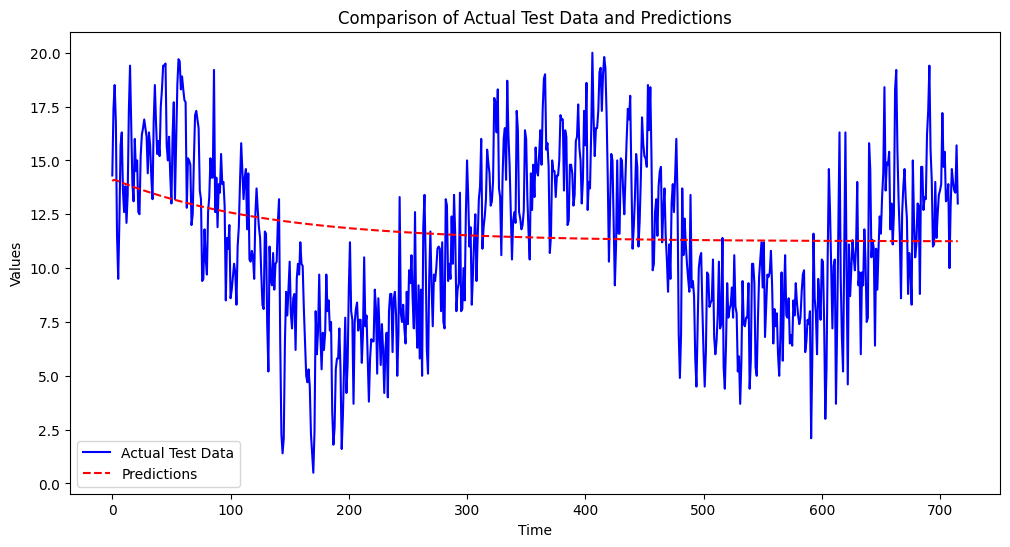

In [47]:
# Plotting the predictions for test data
plt.figure(figsize=(12, 6))
plt.plot(test.reset_index(drop=True), label='Actual Test Data', color='blue')
plt.plot(test_predictions.reset_index(drop=True), label='Predictions', color='red', linestyle='--')
plt.title('Comparison of Actual Test Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

We can see that the RMSE on the test set for seasonal ARIMA is a little bit better than non-seasonal ARIMA, but it also does not capture well the seasonal component. We will next use Prophet to predict.

***8. Prophet***

For Prophet model, we just need two parameters: ds (representing time) and y (representing min_temp).

In [48]:
# Create df_reset to fit the prophet model, change column name min_temp to y
df_reset = df.rename(columns={'date': 'ds', 'min_temp': 'y'})
# Rename 'Date' column to 'ds' to fit Prophet's expected column name
df_reset = df_reset.rename(columns={'Date': 'ds'})
df_reset

,ds,y,day,week,month,year,season
date,,,,,,,
1981-01-02,1/2/1981,17.9,2,1,1,1981,3
1981-01-03,1/3/1981,18.8,3,1,1,1981,3
1981-01-04,1/4/1981,14.6,4,1,1,1981,3
1981-01-05,1/5/1981,15.8,5,2,1,1981,3
1981-01-06,1/6/1981,15.8,6,2,1,1981,3
...,...,...,...,...,...,...,...
1990-12-27,12/27/1990,14.0,27,52,12,1990,3
1990-12-28,12/28/1990,13.6,28,52,12,1990,3
1990-12-29,12/29/1990,13.5,29,52,12,1990,3


In [49]:
!pip install -qqq prophet

In [50]:
from prophet import Prophet

/Users/khanhdam/.local/share/virtualenvs/ARIMA_Prophet_LSTM_TimeSeries-PUFzfPZF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
# Split the reset dataset
p_train, p_test = train_test_split(df_reset, test_size=0.2, shuffle=False)

# Initialize the Prophet model
model = Prophet()

# Fit the model with the DataFrame
model.fit(p_train)

16:38:40 - cmdstanpy - INFO - Chain [1] start processing
16:38:41 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Create a future DataFrame for prediction dates
future = model.make_future_dataframe(periods=len(p_test))

# Predict future values
forecast = model.predict(future)

In [53]:
# Extract the predicted and actual values
y_pred = forecast['yhat'][-len(p_test):]  # Last 'len(p_test)' predictions
y_true = p_test['y'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'RMSE: {rmse}')

RMSE: 2.6965689222164526


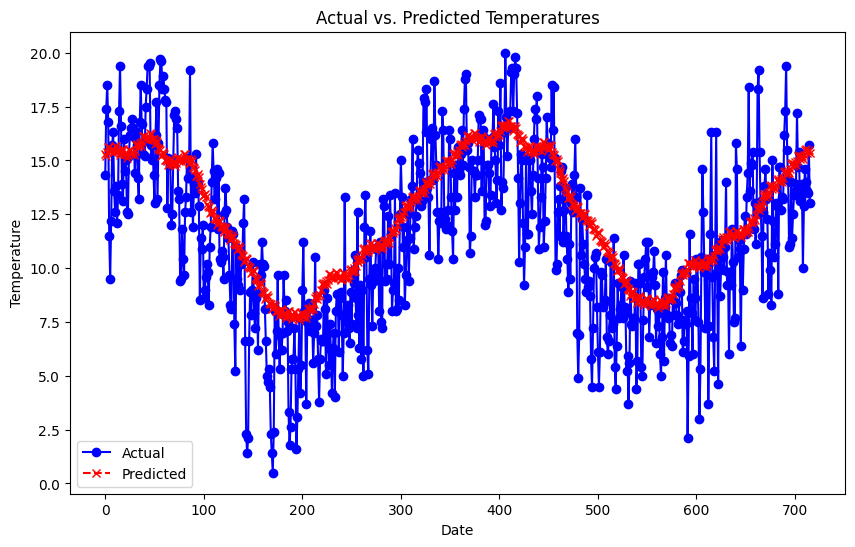

In [54]:
# Plot the results for test set
y_pred = y_pred.values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

From the result and the plot, we can see that Prophet can capture well seasonal component and the result is better than ARIMA.

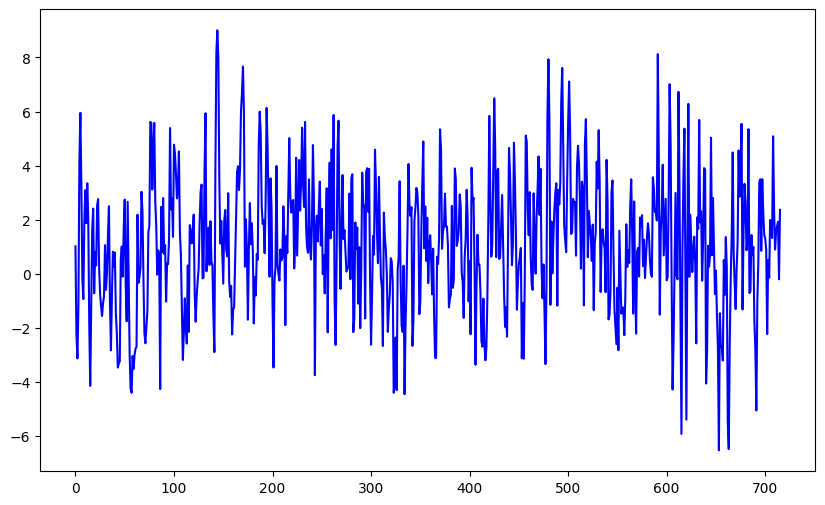

In [55]:
# Residuals plot
residuals = y_pred - y_true
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.show()

The residuals seem to fluctuate around a mean of zero and have a uniform variance between (-6, 8) (probably there are still outliers).

<Axes: ylabel='Count'>

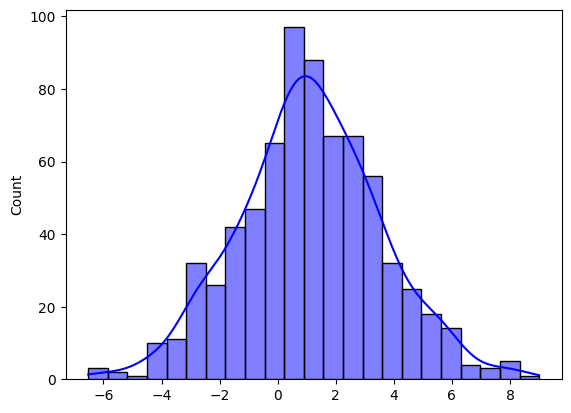

In [56]:
# Histogrm of residuals
sns.histplot(
    data = residuals,
    kde = True,
    color = 'blue'
)

***9 Cyclical encoding***

Because temperature data has strong seasonal nature, we can cyclicaly encode days (of year), weeks, months, seasons by sin and cosine for LSTM prediction.

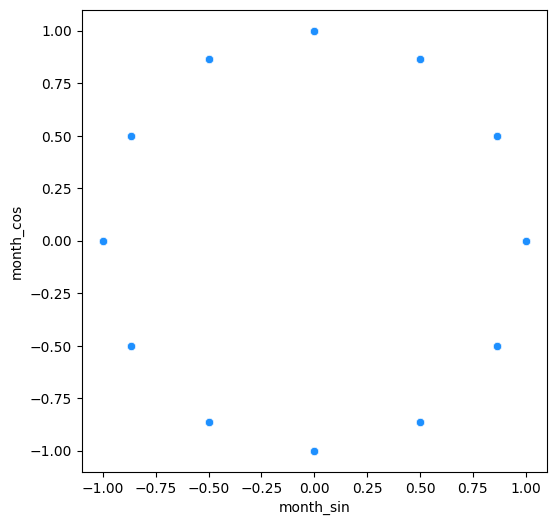

In [57]:
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

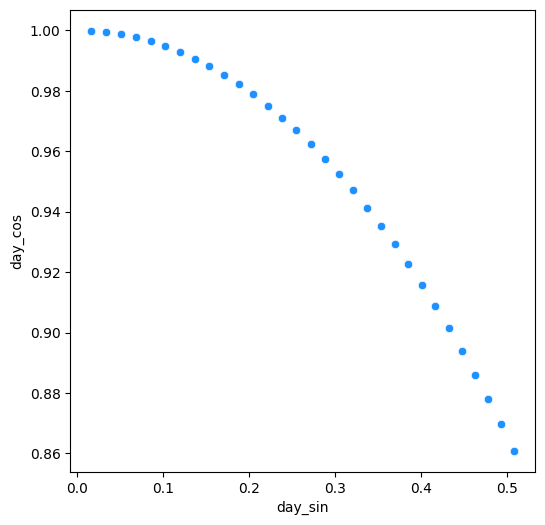

In [58]:
df['day_sin'] = np.sin(2*np.pi*df['day']/365)
df['day_cos'] = np.cos(2*np.pi*df['day']/365)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.day_sin, y=df.day_cos, color='dodgerblue')
plt.show()

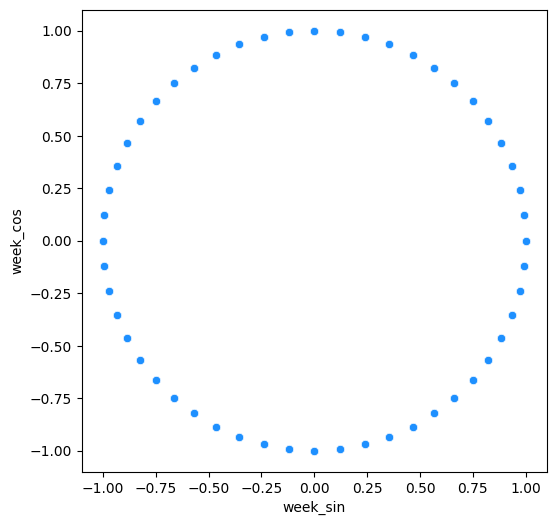

In [59]:
df['week_sin'] = np.sin(2*np.pi*df['week']/52)
df['week_cos'] = np.cos(2*np.pi*df['week']/52)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.week_sin, y=df.week_cos, color='dodgerblue')
plt.show()

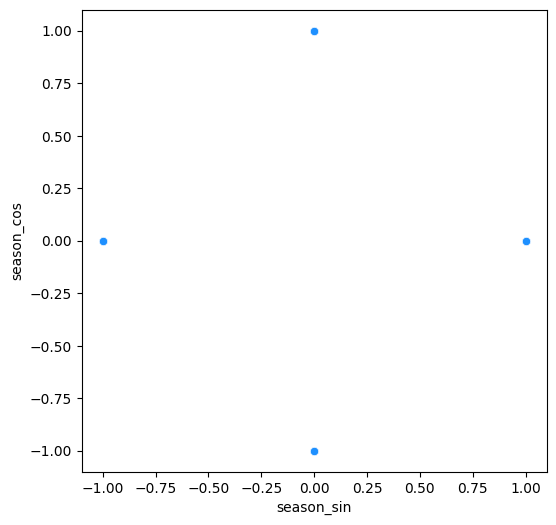

In [60]:
df['season_sin'] = np.sin(2*np.pi*df['season']/4)
df['season_cos'] = np.cos(2*np.pi*df['season']/4)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.season_sin, y=df.season_cos, color='dodgerblue')
plt.show()

In [61]:
df.head()

,Date,min_temp,day,week,month,year,season,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos,season_sin,season_cos
date,,,,,,,,,,,,,,,
1981-01-02,1/2/1981,17.9,2,1,1,1981,3,0.5,0.866025,0.034422,0.999407,0.120537,0.992709,-1.0,-1.836970e-16
1981-01-03,1/3/1981,18.8,3,1,1,1981,3,0.5,0.866025,0.051620,0.998667,0.120537,0.992709,-1.0,-1.836970e-16
1981-01-04,1/4/1981,14.6,4,1,1,1981,3,0.5,0.866025,0.068802,0.997630,0.120537,0.992709,-1.0,-1.836970e-16
1981-01-05,1/5/1981,15.8,5,2,1,1981,3,0.5,0.866025,0.085965,0.996298,0.239316,0.970942,-1.0,-1.836970e-16
1981-01-06,1/6/1981,15.8,6,2,1,1981,3,0.5,0.866025,0.103102,0.994671,0.239316,0.970942,-1.0,-1.836970e-16


In [62]:
df.drop(['Date','day', 'week', 'month', 'season'], axis=1, inplace=True)

In [63]:
df.head()

,min_temp,year,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos,season_sin,season_cos
date,,,,,,,,,,
1981-01-02,17.9,1981,0.5,0.866025,0.034422,0.999407,0.120537,0.992709,-1.0,-1.836970e-16
1981-01-03,18.8,1981,0.5,0.866025,0.051620,0.998667,0.120537,0.992709,-1.0,-1.836970e-16
1981-01-04,14.6,1981,0.5,0.866025,0.068802,0.997630,0.120537,0.992709,-1.0,-1.836970e-16
1981-01-05,15.8,1981,0.5,0.866025,0.085965,0.996298,0.239316,0.970942,-1.0,-1.836970e-16
1981-01-06,15.8,1981,0.5,0.866025,0.103102,0.994671,0.239316,0.970942,-1.0,-1.836970e-16


***10. LSTM***

LSTM is a powerful neural network for time series prediction. We will use the data of 365 previous days to predict the next day.

In [64]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the dataset
        if end_ix > len(data)-1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, 0:], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [65]:
data = df.values
n_steps = 365
X, y = create_sequences(data, n_steps)

In [66]:
print(X.shape)
print(y.shape)

(3211, 365, 10)
(3211,)


In [67]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [68]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [69]:
# Remember to turn GPU on for LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam


num_features = 10  
num_time_steps = 365  
optimizer = Adam(learning_rate=0.0003)

# Define the model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(num_time_steps, num_features)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  
model.compile(optimizer=optimizer, loss='mse')

# Fit model
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
65/65 [==============================] - 19s 272ms/step - loss: 76.9763 - val_loss: 49.7272
Epoch 2/100
65/65 [==============================] - 18s 277ms/step - loss: 19.8246 - val_loss: 16.0898
Epoch 3/100
65/65 [==============================] - 17s 262ms/step - loss: 14.6153 - val_loss: 14.7708
Epoch 4/100
65/65 [==============================] - 18s 283ms/step - loss: 14.6296 - val_loss: 14.8201
Epoch 5/100
65/65 [==============================] - 19s 279ms/step - loss: 14.6242 - val_loss: 14.9593
Epoch 6/100
65/65 [==============================] - 17s 261ms/step - loss: 14.6232 - val_loss: 15.2193
Epoch 7/100
65/65 [==============================] - 18s 276ms/step - loss: 14.6140 - val_loss: 15.1167
Epoch 8/100
65/65 [==============================] - 17s 263ms/step - loss: 14.6182 - val_loss: 15.0178
Epoch 9/100
65/65 [==============================] - 17s 258ms/step - loss: 14.6044 - val_loss: 15.2700
Epoch 10/100
65/65 [==============================] - 17s 263ms/

In [70]:
# Calculate MSE for training data
y = model.predict(X_train)
mse = mean_squared_error(y_train, y) 
rmse = sqrt(mse)

print("RMSE:", rmse)

81/81 [==============================] - 7s 81ms/step
RMSE: 2.4045009448961228


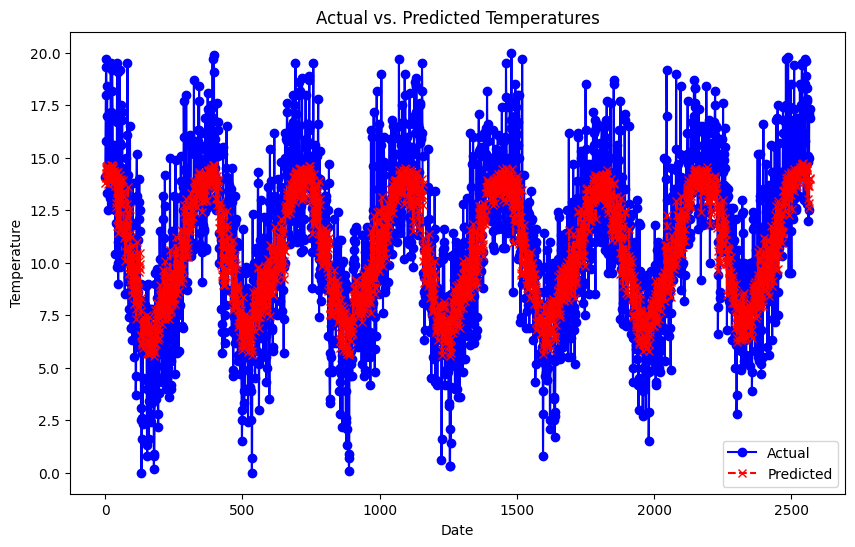

In [71]:
# Plot the results for training data
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual', color='blue', marker='o')
plt.plot(y, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [72]:
# Predict on your test set
y_pred = model.predict(X_test) 

# Calculate MSE
mse = mean_squared_error(y_test, y_pred) 

# Calculate RMSE
rmse = sqrt(mse)

print("RMSE:", rmse)

21/21 [==============================] - 2s 80ms/step
RMSE: 2.303300136082187


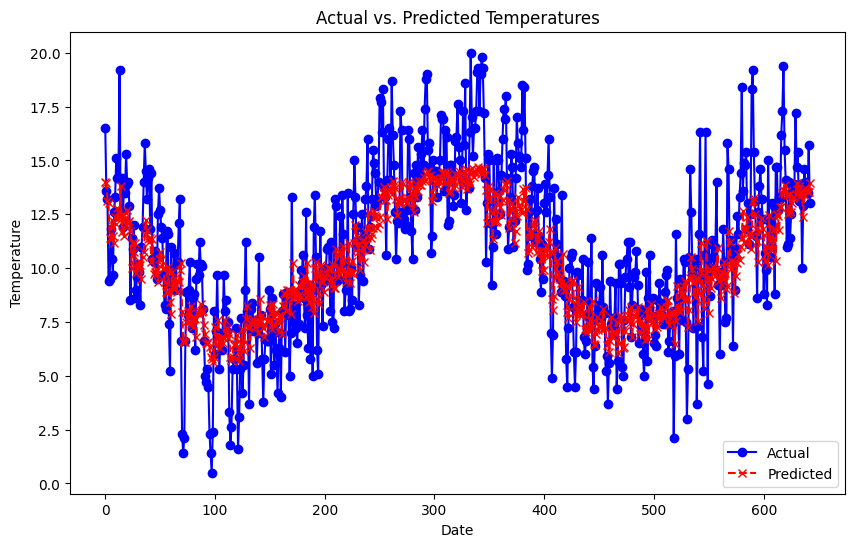

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [74]:
y_pred = y_pred.flatten()

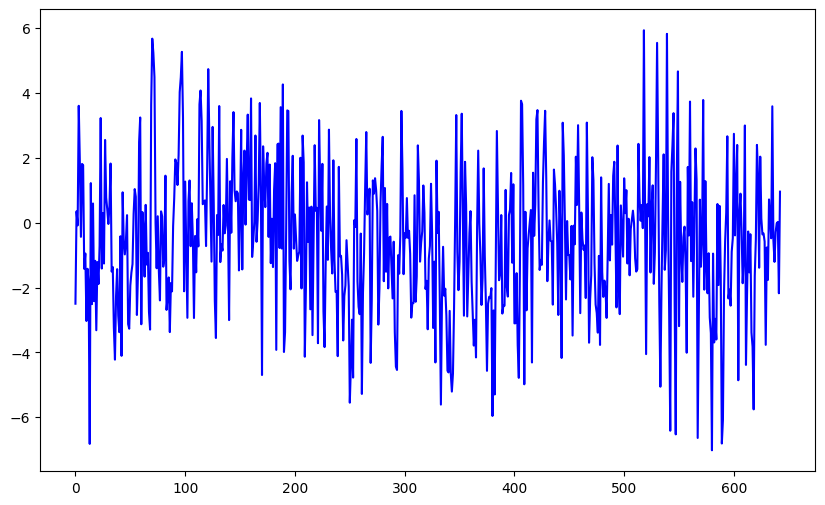

In [75]:
# Residuals plot
residuals = y_pred - y_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.show()

The residual terms seem to fluctuate around a mean of zero and have a uniform variance between (-6, 6).

<Axes: ylabel='Count'>

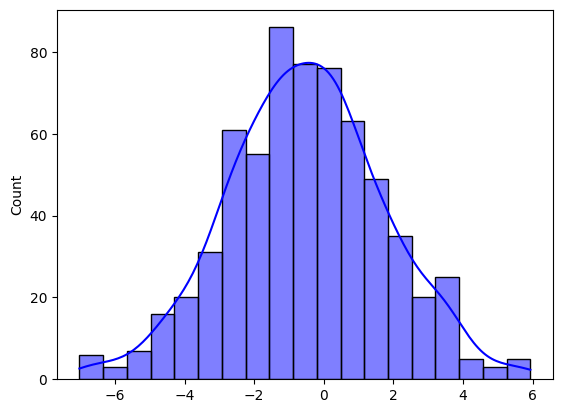

In [76]:
# Histogrm of residuals
sns.histplot(
    data = residuals,
    kde = True,
    color = 'blue'
)

***Conclusion***

For this dataset, the best model for this problem is LSTM. However, Prophet is also a great choice when resources are limited (eg. GPUs).